In [1]:
import pandas as pd 
import numpy as np
import os 
import json
from math import ceil, floor

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,chi2

from sklearn.preprocessing import LabelEncoder,scale
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.utils.multiclass import unique_labels

from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 11})

import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords




In [2]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;-]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
Number_RE = re.compile('[*^0-9]')
Bad_underline = re.compile('[*_*]')
RemoveTag = re.compile('&lt;|br&gt;|b&gt;|ul&gt;|li&gt;')


def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = RemoveTag.sub('',text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = Number_RE.sub(' ', text) # replace Number symbols by space in text
    text = Bad_underline.sub(' ', text) # replace Underline symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text

    return text
RemoveLastSpace = re.compile(' $')

def clean_text_category(text):
    text = RemoveLastSpace.sub('',text)
    return text
    

In [3]:
def classNumberThreshold(arr):
    dropCategory = []

    for key,value in arr.items():
        if(value<=30):
            dropCategory.append(key)
    return dropCategory

In [4]:
df = pd.read_csv('../example/amazon_co-ecommerce_sample.csv')

In [5]:
df = df[pd.notnull(df['amazon_category_and_sub_category'])]
df = df[pd.notnull(df['description'])]
df = df[pd.notnull(df['uniq_id'])]
category = []
subcategory = []
sub2category = []
for ele in df['amazon_category_and_sub_category'].apply(lambda x: str(x).split('>')):
    category.append(ele[0])
    if(len(ele)>2):
        subcategory.append(ele[1])
        sub2category.append(ele[2])
    elif(len(ele)>1):
        subcategory.append(ele[1])
        sub2category.append(np.NaN)
    else:
        subcategory.append(np.NaN)
        sub2category.append(np.NaN)

data= {'uniq_id':df['uniq_id'], 'product_name':df['product_name'],'category_main':category,'category_sub1':subcategory,'description':df['description']}
df = pd.DataFrame(data)
df['description'] = df['description'].apply(clean_text)
df.category_main = df['category_main'].apply(clean_text_category)
df.category_sub1 = df['category_sub1'].apply(clean_text_category)

df = df[pd.notnull(df['category_main'])]
df = df[pd.notnull(df['category_sub1'])]


In [6]:
dropCategoryCode  = classNumberThreshold(df.category_main.value_counts())
dropSubCategoryCode  = classNumberThreshold(df.category_sub1.value_counts())

for i in dropCategoryCode:
    df = df[df.category_main!=i]
    
for i in dropSubCategoryCode:
    df = df[df.category_sub1!=i]



In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8189 entries, 0 to 9998
Data columns (total 5 columns):
uniq_id          8189 non-null object
product_name     8189 non-null object
category_main    8189 non-null object
category_sub1    8189 non-null object
description      8189 non-null object
dtypes: object(5)
memory usage: 383.9+ KB


In [8]:
df = df.reset_index(drop=True)

In [9]:
le = LabelEncoder()
le.fit(df.category_main)
target = le.classes_
labels = le.transform(df['category_main'])

le.fit(df.category_sub1)
subtarget = le.classes_
sublabels = le.transform(df['category_sub1'])

In [10]:
tfidfconverter = TfidfVectorizer(min_df=5, max_df=0.7)
X = tfidfconverter.fit_transform(df.description)
featureNames = tfidfconverter.get_feature_names()

In [11]:
Datalist = pd.DataFrame({'label':labels,'sublabel':sublabels})

In [12]:
X_train, X_test, y_train_info, y_test_info = train_test_split(X,Datalist , 
                                                    test_size=0.1, random_state = 27)

In [13]:
yst_train = y_train_info.label
yst_test = y_test_info.label
ynd_train = y_train_info.sublabel
ynd_test = y_test_info.sublabel


In [14]:
BestSize  = [ele for ele in range(100, len(featureNames), 100) ]
Models = []
Scores = []
SelectModels  = []
for ele in range(100, len(featureNames), 100):
    print("--- Best "+ str(ele) + " features \n")
    selectBest = SelectKBest(chi2, k= ele)
    model = LinearSVC(random_state=42,class_weight="balanced")
    K_best_linearsvc = Pipeline([('SelectBest', selectBest), ('linearSVC', model)])
    K_best_linearsvc.fit(X_train,yst_train)
    score = K_best_linearsvc.score(X_test,yst_test)
    Models.append(K_best_linearsvc)
    Scores.append(score)

bestModel = Models[np.argmax(Scores)]
bestSize = BestSize[np.argmax(Scores)]

--- Best 100 features 

--- Best 200 features 

--- Best 300 features 

--- Best 400 features 

--- Best 500 features 

--- Best 600 features 

--- Best 700 features 

--- Best 800 features 

--- Best 900 features 

--- Best 1000 features 

--- Best 1100 features 

--- Best 1200 features 

--- Best 1300 features 

--- Best 1400 features 

--- Best 1500 features 

--- Best 1600 features 

--- Best 1700 features 

--- Best 1800 features 

--- Best 1900 features 

--- Best 2000 features 

--- Best 2100 features 

--- Best 2200 features 

--- Best 2300 features 

--- Best 2400 features 

--- Best 2500 features 

--- Best 2600 features 

--- Best 2700 features 

--- Best 2800 features 

--- Best 2900 features 

--- Best 3000 features 

--- Best 3100 features 

--- Best 3200 features 

--- Best 3300 features 

--- Best 3400 features 

--- Best 3500 features 

--- Best 3600 features 

--- Best 3700 features 

--- Best 3800 features 

--- Best 3900 features 

--- Best 4000 features 

--- Best 

FileNotFoundError: [Errno 2] No such file or directory: 'AmazonHC/5500BestLinearSVC.sav'

In [15]:

# save the model to disk
filename = 'AmazonHC/'+str(bestSize)+'BestLinearSVC.sav'
joblib.dump(bestModel, filename)



ystConfidence = bestModel.decision_function(X_test)

ystPred = bestModel.predict(X_test)


In [16]:
for ele in np.unique(yst_train):
    sublist = y_train_info[y_train_info['label']==ele]
    Xarr = X.toarray()
    subfeatures = [Xarr[index] for index in sublist.index]
    sublabel = sublist['sublabel']
    numofSublabel  = len(np.unique(sublabel))
    if (numofSublabel>1): 
        selectBestsub = SelectKBest(chi2, k= bestSize)
        submodel = LinearSVC(random_state=42,class_weight="balanced")
        K_best_sublinearsvc = Pipeline([('SelectBest', selectBestsub), ('linearSVC', submodel)])
        K_best_sublinearsvc.fit(subfeatures,sublabel)
    else:
        K_best_sublinearsvc = np.unique(sublabel)[0]
    subfilename = 'AmazonHC/'+str(ele)+'.sav'
    joblib.dump(K_best_sublinearsvc, subfilename)
    

In [17]:
selectBestsub = SelectKBest(chi2, k= bestSize)
flatmodel = LinearSVC(random_state=42,class_weight="balanced")
K_best_flat = Pipeline([('SelectBest', selectBestsub), ('linearSVC', flatmodel)])
K_best_flat.fit(X_train,ynd_train)
filename = 'AmazonHC/'+'flat.sav'
joblib.dump(K_best_flat, filename)

['AmazonHC/flat.sav']

In [18]:
totalConfidenceSize = ystConfidence.shape[0]*ystConfidence.shape[1]
Confidence1DArr = ystConfidence.reshape(totalConfidenceSize,1)
Max = ceil(max(Confidence1DArr)[0])
Min = floor(min(Confidence1DArr)[0])
NormalisedConfid = [round((max(ele)-Min)/(Max-Min),2) for ele in ystConfidence]
productID = [ df[df.index==ele]['uniq_id'].values[0] for ele in y_test_info.index ]
ProductDescription =[ df[df.index==ele]['description'].values[0] for ele in y_test_info.index ]
LinearSVCResult = pd.DataFrame({'index':y_test_info.index,'id':productID,'description':ProductDescription,
                         'trueClass': yst_test,'trueClassNaem':target[yst_test] ,
                         'predictClass':ystPred,'predictClassName':target[ystPred],'sublabel':y_test_info['sublabel'],
                         'Confidence':NormalisedConfid})

In [19]:
def draw_confidenceReport(data):
    num = [ ele*0.01 for ele in range(20,81,2)]
    totalitems = []
    correct = []
    incorrect = []
    for ele in num:
        Threshold = data[data.Confidence>ele]
        correct.append(len(Threshold[Threshold['trueClass']==Threshold['predictClass']].index))
        incorrect.append(len(Threshold[Threshold['trueClass']!=Threshold['predictClass']].index))
        totalitems.append(len(Threshold.index))
    
    ClassfiedProportion = [ ele/len(data.index) for ele in totalitems]
    
    Acc =[]
    for ele in zip(correct,totalitems):
        if (ele[1]==0):
            Acc.append(0)
        else:
            Acc.append(ele[0]/ele[1])

    fig,ax  = plt.subplots()
    
    color = 'tab:blue'
    ax.scatter(num,ClassfiedProportion,label="Proportion classified",color=color)
    ax.set_xlabel("Confidence Score")
    ax.set_ylabel("Proportion classified", color=color)
    ax.xaxis.set_ticks(np.arange(0,1.1,0.1))
    ax.yaxis.set_ticks(np.arange(0,1.1,0.1))
    ax.tick_params(axis='y', labelcolor=color)

    color = 'tab:red'

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.scatter(num,Acc,label="Accuracy", color=color)
    ax2.set_ylabel("Accuracy", color=color)
    ax2.yaxis.set_ticks(np.arange(0,1.1,0.1))
    ax2.tick_params(axis='y', labelcolor=color)

    ax.grid()

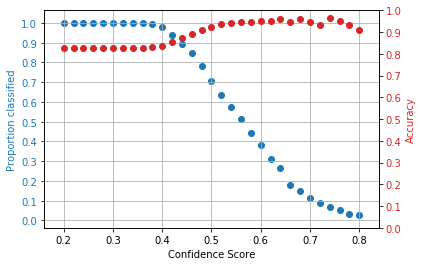

In [20]:
draw_confidenceReport(LinearSVCResult)

In [21]:
Data_to_predict_next_level = LinearSVCResult[LinearSVCResult['Confidence']>0.45]

In [22]:
Data_to_predict_next_level.head()

,index,id,description,trueClass,trueClassNaem,predictClass,predictClassName,sublabel,Confidence
3038,3038,ae17fcd989c177becd530647483f642c,lucy locket butterfly mask pretty butterfly ma...,5,Fancy Dress,5,Fancy Dress,1,0.72
2980,2980,1a8272fd1aa18103da2327b19ca951c5,red gold mask stick,5,Fancy Dress,5,Fancy Dress,1,0.59
5695,5695,c42b22eb032251bc72df7f4c44902aa2,fan tell thing cooler one faceless soldiers em...,2,Characters & Brands,2,Characters & Brands,40,0.49
612,612,74d2f09e30529fe19645cdaa86d5a79b,let race collect die cast characters race stra...,3,Die-Cast & Toy Vehicles,2,Characters & Brands,43,0.61
7863,7863,e721747a2a536cb1827e739216a7a2bd,welcome k offer combined items postage uk comb...,0,Arts & Crafts,0,Arts & Crafts,8,0.66


In [23]:
Xarr = X.toarray()
def predictNextLevel(predictParent, index):
    filename = 'AmazonHC/'+str(predictParent)+'.sav'
    loaded_model = joblib.load(open(filename, 'rb'))
    if(isinstance(loaded_model,Pipeline)):
        yndPre = loaded_model.predict([Xarr[index]])
        return yndPre[0]
    else:
        return loaded_model


In [24]:
%time
ynd_Pre = [ predictNextLevel(ele[5], ele[0]) for ele in LinearSVCResult.values ] 


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs


In [25]:
%time 
modified_ynd_Pre = [ predictNextLevel(ele[5], ele[0]) for ele in Data_to_predict_next_level.values ] 


CPU times: user 17 µs, sys: 7 µs, total: 24 µs
Wall time: 5.72 µs


In [26]:

ynd_flat = K_best_flat.predict(X_test) 

In [27]:
print(classification_report(yst_test, ystPred,target_names=target))

                           precision    recall  f1-score   support

            Arts & Crafts       0.75      0.93      0.83        61
      Baby & Toddler Toys       0.50      0.50      0.50         4
      Characters & Brands       0.77      0.65      0.71        83
  Die-Cast & Toy Vehicles       0.85      0.91      0.88       108
      Dolls & Accessories       0.87      0.92      0.89        37
              Fancy Dress       0.91      0.91      0.91        56
       Figures & Playsets       0.77      0.77      0.77       106
                    Games       0.90      0.83      0.86        93
                  Hobbies       0.83      0.78      0.81       148
        Jigsaws & Puzzles       0.84      0.89      0.86        18
           Party Supplies       0.84      0.86      0.85        50
             Pretend Play       0.60      0.60      0.60         5
Puppets & Puppet Theatres       0.92      1.00      0.96        22
    Sports Toys & Outdoor       0.79      0.79      0.79     

In [28]:
print(classification_report(ynd_test,ynd_flat,target_names=subtarget))
with open('AmazonHC/FlatSVCHCReport.txt', 'w') as file:
    file.write(classification_report(ynd_test,ynd_flat,target_names=subtarget))

                                       precision    recall  f1-score   support

                          3-D Puzzles       1.00      0.25      0.40         4
                          Accessories       0.84      0.50      0.63        62
                             Art Sand       0.86      1.00      0.92         6
         Banners, Stickers & Confetti       0.78      0.72      0.75        25
                           Beach Toys       0.67      0.71      0.69        14
                        Brain Teasers       1.00      1.00      1.00         3
                           Card Games       0.68      0.56      0.61        27
                                Chess       1.00      1.00      1.00         7
                Children's Craft Kits       0.71      0.82      0.76        33
    Collectible Figures & Memorabilia       0.47      0.60      0.53        15
                    Colouring Pencils       0.33      0.67      0.44         3
             Colouring Pens & Markers       0.82   

In [29]:
print(classification_report(ynd_test,ynd_Pre,target_names=subtarget))
with open('AmazonHC/OriginalSVCHCReport.txt', 'w') as file:
    file.write(classification_report(ynd_test,ynd_Pre,target_names=subtarget))

                                       precision    recall  f1-score   support

                          3-D Puzzles       1.00      0.25      0.40         4
                          Accessories       0.73      0.56      0.64        62
                             Art Sand       0.86      1.00      0.92         6
         Banners, Stickers & Confetti       0.82      0.72      0.77        25
                           Beach Toys       0.73      0.79      0.76        14
                        Brain Teasers       1.00      1.00      1.00         3
                           Card Games       0.67      0.67      0.67        27
                                Chess       1.00      1.00      1.00         7
                Children's Craft Kits       0.73      0.82      0.77        33
    Collectible Figures & Memorabilia       0.89      0.53      0.67        15
                    Colouring Pencils       0.17      0.33      0.22         3
             Colouring Pens & Markers       0.71   

In [30]:
print(classification_report(Data_to_predict_next_level['sublabel'],modified_ynd_Pre,target_names=subtarget))
with open('AmazonHC/ModifiedSVCHCReport.txt', 'w') as file:
    file.write(classification_report(Data_to_predict_next_level['sublabel'],modified_ynd_Pre,target_names=subtarget))

                                       precision    recall  f1-score   support

                          3-D Puzzles       1.00      0.33      0.50         3
                          Accessories       0.75      0.60      0.67        55
                             Art Sand       0.86      1.00      0.92         6
         Banners, Stickers & Confetti       0.82      0.75      0.78        24
                           Beach Toys       0.69      0.82      0.75        11
                        Brain Teasers       1.00      1.00      1.00         3
                           Card Games       0.72      0.82      0.77        22
                                Chess       1.00      1.00      1.00         6
                Children's Craft Kits       0.81      0.81      0.81        32
    Collectible Figures & Memorabilia       1.00      0.55      0.71        11
                    Colouring Pencils       0.00      0.00      0.00         2
             Colouring Pens & Markers       0.73   

/home/justin/mscproject/app/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
